In [261]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import astropy
import astropy.constants as const
import pandas as pd
from scipy.integrate import simps
import scipy.stats as stats
from astropy.modeling import models, fitting
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.constants as const

In [148]:
s2a = pd.read_csv('./resources/zprofile-2a.tsv', sep='\t', skiprows=6, header=None)
s2b = pd.read_csv('./resources/zprofile-2b.tsv', sep='\t', skiprows=6, header=None)
s2c = pd.read_csv('./resources/zprofile-2c.tsv', sep='\t', skiprows=6, header=None)

colnames = ['freq', 'intensity']
s2a.columns, s2a.name = colnames, '2a'
s2b.columns, s2b.name = colnames, '2b'
s2c.columns, s2c.name = colnames, '2c'

spec = [s2a, s2b, s2c]
labels = ['2a', '2b', '2c']

In [307]:
cosmo = FlatLambdaCDM(H0=70, Tcmb0=2.72548, Om0=0.3) # default Tcmb0=0 gives very similar results
co_j32_freq = 345.8 # GHz
co32_10_ratio = 0.27
alpha_co = 4.6
sfr = ufloat(99, 9)
rmse = [1.11e-4, 1.15e-4, 1.08e-4]

In [150]:

fit_g = fitting.LevMarLSQFitter()

In [242]:
 g(s.freq[:-1]).dot(np.abs(np.diff(vrad / 1000))).dtype

uncertainties.core.AffineScalarFunc.dtype

In [312]:
n = 500

sims = []
all_means = []
all_stds = []
all_fluxes = []
# all_flux2s = []

for sidx, s in enumerate(spec):
    g_init = models.Gaussian1D(amplitude=max(s.intensity), mean=88.2, stddev=.3, bounds={'mean': (88, 88.5)})
    vrad = velocity_radio(s.freq, co_j32_freq, 2.92)
    means = np.zeros(n)
    stds = np.zeros(n)
    fluxes = np.zeros(n)
#     flux2 = np.zeros(n)
    for i in np.arange(n):
        sim = np.random.normal(loc=s.intensity, scale=rmse[sidx])
        g = fit_g(g_init, s.freq, sim)

        sims.append(sim)
        means[i] = g.mean.value
        stds[i] = g.stddev.value
#         fluxes[i] = simps(g(s.freq), x=s.freq)
#         fluxes[i] = g(s.freq).sum()
        fluxes[i] = g(s.freq)[:-1].dot(np.abs(np.diff(vrad / 1000)))
#         flux2[i] = np.array([i.n for i in fluxes])
    
    all_means.append(means)
    all_stds.append(stds)
    all_fluxes.append(fluxes)
    print([f'{i:.3f}' for i in [means.mean(), means.std(), 2 * np.sqrt(2 * np.log(2)) * stds.mean(), 2 * np.sqrt(2 * np.log(2)) * stds.std()]])
    print(fluxes.mean(), fluxes.std())
    print('\n')

['88.135', '0.169', '0.576', '0.387']
0.12475715726064018 0.08133105896792205


['88.220', '0.078', '0.226', '0.259']
0.21802814994998881 0.06289862820581334


['88.203', '0.059', '0.148', '0.402']
0.16586025421023903 0.04740866902091376




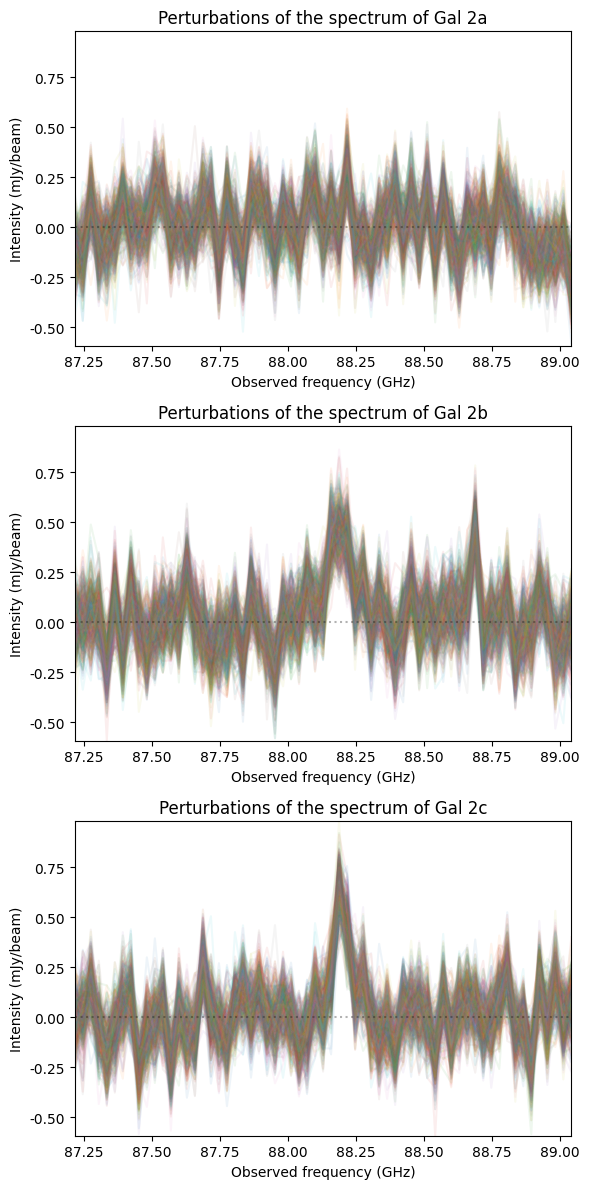

In [384]:
fig = plt.figure(figsize=(6, 12), dpi=100)
for idx, gal in enumerate(np.split(np.array(sims), (500, 1000))):
    ax = fig.add_subplot(3, 1, idx+1)
    ax.set_title(f'Perturbations of the spectrum of Gal {labels[idx]}')
    ax.yaxis.set_major_locator(plt.MaxNLocator(7))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e3:.2f}'))
    ax.set_ylabel('Intensity (mJy/beam)')
    ax.set_xlabel('Observed frequency (GHz)')
    ax.set_ylim(np.min(sims), np.max(sims))
    ax.set_xlim(np.min(spec[idx].freq), np.max(spec[idx].freq))
    
    for sim in gal:
        ax.plot(spec[idx].freq, sim, alpha=0.075)
        
    ax.axhline(0, linestyle=':', c='black', alpha=0.3)
        
    plt.tight_layout()
    
plt.savefig('figs/perturbations.pdf')

In [315]:
def z_from_freq(obs_freq, rest_freq):
    """ Given (arrays of) observed and rest frequencies, calculate redshift.
    """
    return (rest_freq / obs_freq) - 1

def line_luminosity(fluxes, lum_dists, zs, freq_obs):
    """ See first eqn. on Carilli and Walter 2013 p. 9
    """
    return (const.c**2 / (2 * const.k_B) * fluxes * np.square(lum_dists) / (np.power(1+zs, 3) * np.square(freq_obs))).to(u.K * u.km * u.pc**2 / u.s)

In [323]:
pp = lambda x,: print([f'{i:.3E}' for i in x])

In [366]:
obs_freqs = np.array([ufloat(mean.mean(), mean.std()) for mean in all_means])
fwhms = np.array([2 * np.sqrt(2 * np.log(2)) * ufloat(std.mean(), std.std()) for std in all_stds])
linefluxes = np.array([ufloat(flux.mean(), flux.std()) for flux in all_fluxes])
redshifts = z_from_freq(obs_freqs, co_j32_freq)
lum_dists = np.array(list(ufloat(nom, err) for nom, err in zip(cosmo.luminosity_distance([i.n for i in redshifts]).value, cosmo.luminosity_distance([i.s for i in redshifts]).value)))
linelumsco32 = 3.25e7 * linefluxes * np.square(lum_dists) / (np.power(1 + redshifts, 3) * np.square(obs_freqs))
linelumsco10 = linelumsco32 / co32_10_ratio
mgas = linelumsco10 * alpha_co
amplifications = np.array([ufloat(2.86, .04), ufloat(8.1, .4), ufloat(6.1, .1)])
delensed_mgas = mgas / amplifications
sfe = sfr / delensed_mgas

In [343]:
(np.abs(delensed_mgas[1] - delensed_mgas[2]) / ((delensed_mgas[1] + delensed_mgas[2]) / 2))

0.010530466203835008+/-0.4094251609308218

In [162]:

def z_from_freq(obs_freq, rest_freq):
    """ Given (arrays of) observed and rest frequencies, calculate redshift.
    """
    return (rest_freq / obs_freq) - 1

def velocity_radio(obs_freq, rest_freq, z=0):
    """ Given (arrays of) observed and rest frequencies, calculate radio velocity in m/s.
    Optionally, shift the zero point of the velocity frame into the source by redshifting rest frequency. 
    """
    shifted_rest_freq = rest_freq / (z + 1)
    return (1 - obs_freq / shifted_rest_freq) * const.c.value


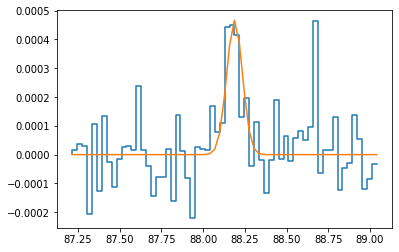

In [205]:
plt.step(s2b.freq, s2b.intensity)
g = fit_g(g_init, s2b.freq, s2b.intensity)
plt.plot(s2b.freq, g(s2b.freq))

In [383]:
(np.abs(np.diff(vrad / 1000)) / np.diff(s2a.freq))[0] * fwhms

array([1955.953365645449+/-1313.8545018960685,
       767.7332376846724+/-880.4002578595922,
       502.25549306308085+/-1366.674502662435], dtype=object)